# Image Segmentation using Deconvolution Network for Semantic Segmentation

By [Akshaj Verma](https://akshajverma.com)


This notebook takes you through an implementation of paper [Learning Deconvolution Network for Semantic Segmentation](https://arxiv.org/pdf/1505.04366.pdf) on the [Chest X-Ray dataset](https://www.kaggle.com/ianmoone0617/chest-x-ray-image-segmentation-with-lungs-mask).

In [2]:
import pathlib
from tqdm.notebook import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler


from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [5]:
ROOT_PATH = "../../../data/computer_vision/image_segmentation/chest-x-ray/"
images_path = ROOT_PATH + "images/"
labels_path = ROOT_PATH + "masks"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## Visualize Data

### Training image

Shape of the image is:  (512, 512, 3) 




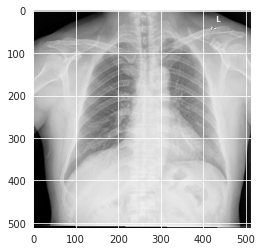

In [7]:
img = Image.open(images_path + "CHNCXR_0001_0.png")
print("Shape of the image is: ", np.array(img).shape, "\n\n")
plt.imshow(img)

### Histogram of image

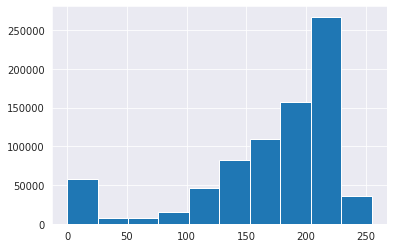

In [8]:
plt.hist(np.array(img).flatten())
plt.show()

### Training label

Shape of the label is:  (224, 224) 




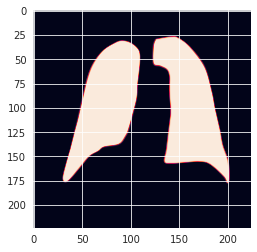

In [14]:
lbl = Image.open(labels_path + "/CHNCXR_0001_0_mask.png").convert('L')
lbl = lbl.resize((224, 224))
print("Shape of the label is: ", np.array(lbl).shape, "\n\n")
plt.imshow(lbl)

### Histogram of label

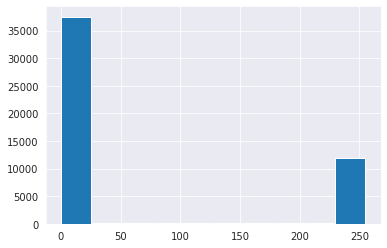

In [13]:
plt.hist(np.array(lbl).flatten())
plt.show()

In [15]:
lbl = np.array(lbl)
lbl[lbl < 255] = 0
lbl[lbl == 255] = 1

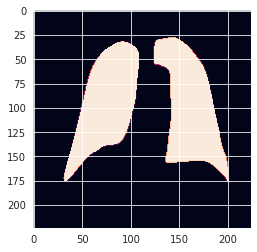

In [16]:
plt.imshow(lbl * 50)

## Data Preprocessing

### Create Transforms

In [17]:
IMAGE_LABEL_SIZE = 224

image_transforms = {
    "train": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ]),
    "test": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])
}

### Create Dataset

#### Path to data

In [18]:
root_path = pathlib.Path(ROOT_PATH)

print("Root path: ", root_path)
print("")

# train paths
train_images_path = root_path.joinpath("images")
train_labels_path = root_path.joinpath("masks")

print("Train Images path: ", train_images_path)
print("Train Labels path: ", train_labels_path)
print("")

Root path:  /content/drive/My Drive/data/chest-x-ray

Train Images path:  /content/drive/My Drive/data/chest-x-ray/images
Train Labels path:  /content/drive/My Drive/data/chest-x-ray/masks



#### Base Dataset Class

In [20]:
class DatasetChestXray(Dataset):
    def __init__(self, images_path, labels_path, image_transform, img_lbl_size):
        super(DatasetChestXray, self).__init__()
        self.images_path = pathlib.Path(images_path)
        self.labels_path = pathlib.Path(labels_path)
        
        self.img_lbl_size = img_lbl_size
        self.transform = image_transform
        
        self.img_file_paths = [file for file in images_path.rglob("**/*.png")]
        self.lbl_file_paths = [file for file in labels_path.rglob("**/*.png")]
        
    def __getitem__(self, idx):
        img_path = str(self.img_file_paths[idx])
        lbl_path = str(self.lbl_file_paths[idx])
                
        img = Image.open(img_path).resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE))
        img = self.transform(img)
        
        lbl = Image.open(lbl_path).convert('L').resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE))
        lbl = np.array(lbl)
        lbl[lbl < 255] = 0
        lbl[lbl == 255] = 1

        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl
    
    def __len__(self):
        assert len(self.img_file_paths) == len(self.lbl_file_paths)
        return len(self.img_file_paths)

#### Train+Val Dataset

In [21]:
train_test_dataset = DatasetChestXray(images_path=train_images_path, labels_path=train_labels_path, image_transform=image_transforms["train"], img_lbl_size=IMAGE_LABEL_SIZE)

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes.

`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

Create a list of indices from 0 to length of dataset.

In [22]:
def create_samplers(dataset, train_percent, val_percent):
    # Create a list of indices from 0 to length of dataset.
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))
    
    # Shuffle the list of indices using `np.shuffle`.
    np.random.shuffle(dataset_indices)
    
    # Create the split index. We choose the split index to be 20% (0.2) of the dataset size.
    train_split_index = int(np.floor(train_percent * dataset_size))
    val_split_index = int(np.floor(val_percent * dataset_size))
    

    # Slice the lists to obtain 2 lists of indices, one for train and other for test.
    # `0-------------------------- train_idx----- val_idx ---------n`

    train_idx = dataset_indices[:train_split_index]
    val_idx = dataset_indices[train_split_index:train_split_index+val_split_index]
    test_idx = dataset_indices[train_split_index+val_split_index:]
    
    # Finally, create samplers.
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    return train_sampler, val_sampler, test_sampler

In [23]:
train_sampler, val_sampler, test_sampler = create_samplers(train_test_dataset, 0.8, 0.1)

### Create Dataloaders

In [24]:
train_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=8, sampler = train_sampler)
val_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=1, sampler = val_sampler)
test_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=1, sampler = test_sampler)

### Data Sanity Check

In [25]:
print("Shape of image from train-loader = ", next(iter(train_loader))[0].shape)
print("Shape of label from train-loader = ", next(iter(train_loader))[1].shape)

print("\nShape of image from val-loader = ", next(iter(val_loader))[0].shape)
print("Shape of label from val-loader = ", next(iter(val_loader))[1].shape)

print("\nShape of image from test-loader = ", next(iter(test_loader))[0].shape)
print("Shape of label from test-loader = ", next(iter(test_loader))[1].shape)

Shape of image from train-loader =  torch.Size([8, 3, 224, 224])
Shape of label from train-loader =  torch.Size([8, 224, 224])

Shape of image from val-loader =  torch.Size([1, 3, 224, 224])
Shape of label from val-loader =  torch.Size([1, 224, 224])

Shape of image from test-loader =  torch.Size([1, 3, 224, 224])
Shape of label from test-loader =  torch.Size([1, 224, 224])


## Deconvolutional Model

In [26]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv_block_1_1 = self.conv_block(c_in=3, c_out=64, kernel_size=3, stride=1, padding=1)
        self.conv_block_1_2 = self.conv_block(c_in=64, c_out=64, kernel_size=3, stride=1, padding=1)
        
        self.conv_block_2_1 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.conv_block_2_2 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        
        self.conv_block_3_1 = self.conv_block(c_in=128, c_out=256, kernel_size=3, stride=1, padding=1)
        self.conv_block_3_2 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.conv_block_3_3 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        
        self.conv_block_4_1 = self.conv_block(c_in=256, c_out=512, kernel_size=3, stride=1, padding=1)
        self.conv_block_4_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.conv_block_4_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.conv_block_5_1 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.conv_block_5_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.conv_block_5_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.conv_fc6 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=7, stride=1, padding=0)
        self.conv_fc7 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=1, stride=1, padding=0)
        
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    
    def forward(self, x):
                                   # 3 x 224 x 224
        x = self.conv_block_1_1(x) # 64 x 224 x 224
        x = self.conv_block_1_2(x) # 64 x 224 x 224
        
        size_1 = x.shape
        x, indices_1 = self.maxpool(x)        # 64 x 112 x 112
        
        x = self.conv_block_2_1(x) # 128 x 112 x 112
        x = self.conv_block_2_2(x) # 128 x 112 x 112
        
        size_2 = x.shape
        x, indices_2 = self.maxpool(x)        # 128 x 56 x 56
        
        x = self.conv_block_3_1(x) # 256 x 56 x 56
        x = self.conv_block_3_2(x) # 256 x 56 x 56
        x = self.conv_block_3_3(x) # 256 x 56 x 56
        
        size_3 = x.shape
        x, indices_3 = self.maxpool(x)        # 256 x 28 x 28
        
        x = self.conv_block_4_1(x) # 512 x 28 x 28
        x = self.conv_block_4_2(x) # 512 x 28 x 28
        x = self.conv_block_4_3(x) # 512 x 28 x 28
        
        size_4 = x.shape
        x, indices_4 = self.maxpool(x)        # 512 x 14 x 14
        
        x = self.conv_block_5_1(x) # 512 x 14 x 14
        x = self.conv_block_5_2(x) # 512 x 14 x 14
        x = self.conv_block_5_3(x) # 512 x 14 x 14 
        
        size_5 = x.shape
        x, indices_5 = self.maxpool(x)        # 512 x 7 x 7
        
        x = self.conv_fc6(x)       # 4096 x 1 x 1
        o = self.conv_fc7(x)       # 4096 x 1 x 1

        pool_indices_dict = {
            "indices_1": indices_1,
            "indices_2": indices_2,
            "indices_3": indices_3,
            "indices_4": indices_4,
            "indices_5": indices_5
        }
        
        pool_size_dict = {
            "size_1" : size_1,
            "size_2" : size_2,
            "size_3" : size_3,
            "size_4" : size_4,
            "size_5" : size_5,
        }
        
        return o, pool_indices_dict, pool_size_dict

        
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU()
        )
        
        return seq_block

In [27]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.deconv_fc6 = nn.ConvTranspose2d(in_channels=4096, out_channels=512, kernel_size=7, stride=1, padding=0)
        
        self.deconv_block_5_3 = self.deconv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.deconv_block_5_2 = self.deconv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.deconv_block_5_1 = self.deconv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.deconv_block_4_3 = self.deconv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.deconv_block_4_2 = self.deconv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.deconv_block_4_1 = self.deconv_block(c_in=512, c_out=256, kernel_size=3, stride=1, padding=1)
        
        self.deconv_block_3_3 = self.deconv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.deconv_block_3_2 = self.deconv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.deconv_block_3_1 = self.deconv_block(c_in=256, c_out=128, kernel_size=3, stride=1, padding=1)
        
        self.deconv_block_2_2 = self.deconv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        self.deconv_block_2_1 = self.deconv_block(c_in=128, c_out=64, kernel_size=3, stride=1, padding=1)
        
        self.deconv_block_1_2 = self.deconv_block(c_in=64, c_out=64, kernel_size=3, stride=1, padding=1)
        self.deconv_block_1_1 = self.deconv_block(c_in=64, c_out=64, kernel_size=3, stride=1, padding=1)
                
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
    
    def forward(self, x, pool_indices_dict, pool_size_dict):
                                     # 4096 x 1 x1
        x = self.deconv_fc6(x)       # 512 x 7 x 7
        
        x = self.max_unpool(x, pool_indices_dict["indices_5"], output_size=pool_size_dict["size_5"])       # 512 x 14 x 14
        
        x = self.deconv_block_5_3(x) # 512 x 14 x 14
        x = self.deconv_block_5_2(x) # 512 x 14 x 14
        x = self.deconv_block_5_1(x) # 512 x 14 x 14
        
        x = self.max_unpool(x, pool_indices_dict["indices_4"], output_size=pool_size_dict["size_4"])       # 512 x 28 x 28
        
        x = self.deconv_block_4_3(x) # 512 x 28 x 28
        x = self.deconv_block_4_2(x) # 512 x 28 x 28
        x = self.deconv_block_4_1(x) # 256 x 28 x 28
        
        x = self.max_unpool(x, pool_indices_dict["indices_3"], output_size=pool_size_dict["size_3"])       # 256 x 56 x 56
        
        x = self.deconv_block_3_3(x) # 256 x 56 x 56
        x = self.deconv_block_3_2(x) # 256 x 56 x 56
        x = self.deconv_block_3_1(x) # 128 x 56 x 56

        x = self.max_unpool(x, pool_indices_dict["indices_2"], output_size=pool_size_dict["size_2"])       # 128 x 112 x 112
        
        x = self.deconv_block_2_2(x) # 128 x 112 x 112
        x = self.deconv_block_2_1(x) # 64 x 112 x 112
        
        x = self.max_unpool(x, pool_indices_dict["indices_1"], output_size=pool_size_dict["size_1"])       # 64 x 224 x 224
        
        x = self.deconv_block_1_2(x) # 64 x 224 x 224
        o = self.deconv_block_1_1(x) # 64 x 224 x 224
                
        return o
    
    
    def deconv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU()
        )
        
        return seq_block

In [28]:
class ModelDeconv(nn.Module):
    def __init__(self, num_class):
        super(ModelDeconv, self).__init__()
        self.num_class = num_class
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=self.num_class, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
                                                               # 3 x 224 x 224
        x, pool_indices_dict, pool_size_dict = self.encoder(x) # 4096 x 1 x 1
        x = self.decoder(x, pool_indices_dict, pool_size_dict) # 64 x 224 x 224
        
        output = self.final_conv(x)                            # num_class x 224 x 224
        
        return output

In [29]:
model = ModelDeconv(num_class=2)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

ModelDeconv(
  (encoder): Encoder(
    (conv_block_1_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv_block_1_2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv_block_2_1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv_block_2_2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv_block_3_1): Sequential(
      (0): Conv2d(128, 

In [30]:
loss_stats = {
    'train': [],
    "val": []
}

In [31]:
EPOCHS = 100

In [32]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()

    
    if e%20 == 0:
        model_name = "model_idd_seg_fcn8_" + str(e)
        torch.save(model, model_name)
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
                        
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 01: | Train Loss: 0.34346 | Val Loss: 0.18894
Epoch 02: | Train Loss: 0.22584 | Val Loss: 0.21563
Epoch 03: | Train Loss: 0.22017 | Val Loss: 0.21778
Epoch 04: | Train Loss: 0.21232 | Val Loss: 0.17807
Epoch 05: | Train Loss: 0.20755 | Val Loss: 0.24393
Epoch 06: | Train Loss: 0.20236 | Val Loss: 0.18652
Epoch 07: | Train Loss: 0.19990 | Val Loss: 0.21303
Epoch 08: | Train Loss: 0.19994 | Val Loss: 0.22825
Epoch 09: | Train Loss: 0.19625 | Val Loss: 0.17843
Epoch 10: | Train Loss: 0.19108 | Val Loss: 0.23304
Epoch 11: | Train Loss: 0.18932 | Val Loss: 0.14529
Epoch 12: | Train Loss: 0.18173 | Val Loss: 0.18577
Epoch 13: | Train Loss: 0.17973 | Val Loss: 0.17439
Epoch 14: | Train Loss: 0.17664 | Val Loss: 0.20113
Epoch 15: | Train Loss: 0.17558 | Val Loss: 0.20032
Epoch 16: | Train Loss: 0.16808 | Val Loss: 0.12666
Epoch 17: | Train Loss: 0.16110 | Val Loss: 0.15266
Epoch 18: | Train Loss: 0.15633 | Val Loss: 0.16811
Epoch 19: | Train Loss: 0.15363 | Val Loss: 0.14568


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ModelDeconv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 20: | Train Loss: 0.15025 | Val Loss: 0.16752
Epoch 21: | Train Loss: 0.14020 | Val Loss: 0.17681
Epoch 22: | Train Loss: 0.14187 | Val Loss: 0.13290
Epoch 23: | Train Loss: 0.13193 | Val Loss: 0.14656
Epoch 24: | Train Loss: 0.12641 | Val Loss: 0.14999
Epoch 25: | Train Loss: 0.12540 | Val Loss: 0.11503
Epoch 26: | Train Loss: 0.11410 | Val Loss: 0.18399
Epoch 27: | Train Loss: 0.11175 | Val Loss: 0.12642
Epoch 28: | Train Loss: 0.10523 | Val Loss: 0.12155
Epoch 29: | Train Loss: 0.10228 | Val Loss: 0.09408
Epoch 30: | Train Loss: 0.09174 | Val Loss: 0.09828
Epoch 31: | Train Loss: 0.09440 | Val Loss: 0.10205
Epoch 32: | Train Loss: 0.09589 | Val Loss: 0.10216
Epoch 33: | Train Loss: 0.09600 | Val Loss: 0.14794
Epoch 34: | Train Loss: 0.08678 | Val Loss: 0.07493
Epoch 35: | Train Loss: 0.08151 | Val Loss: 0.07787
Epoch 36: | Train Loss: 0.07782 | Val Loss: 0.10801
Epoch 37: | Train Loss: 0.07262 | Val Loss: 0.06839
Epoch 38: | Train Loss: 0.07263 | Val Loss: 0.08041
Epoch 39: | 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

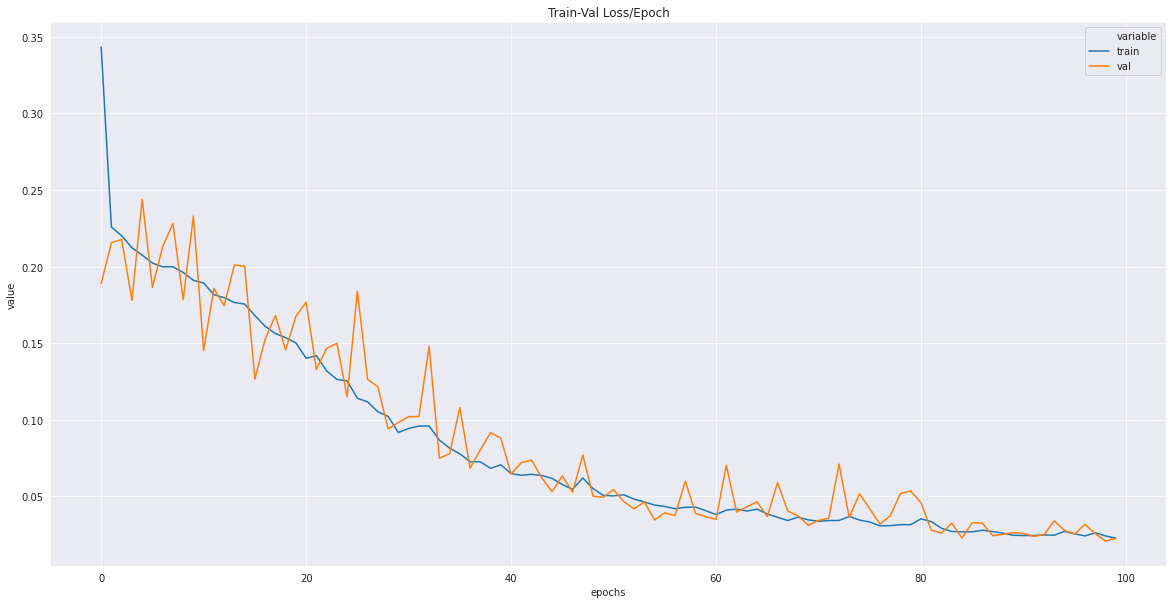

In [33]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

plt.figure(figsize = (20,10))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [34]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_tag = y_pred_tag
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [35]:
total_iou = 0

for i in range(len(y_pred_list)):
    temp_iou = jaccard_score(y_true_list[i].squeeze().flatten(), y_pred_list[i].squeeze().flatten(), average="macro")
    total_iou += temp_iou

In [36]:
print("Cumulative IOU = ", total_iou/len(y_pred_list))

Cumulative IOU =  0.7370336681075524


In [37]:
def array_to_img_for_viz(arr):
    arr = arr * 41
    arr = arr.squeeze()
    arr = np.uint8(arr)
    arr_img = Image.fromarray(arr)
    
    return arr_img  

Text(0.5, 1.0, 'Predicted Mask')

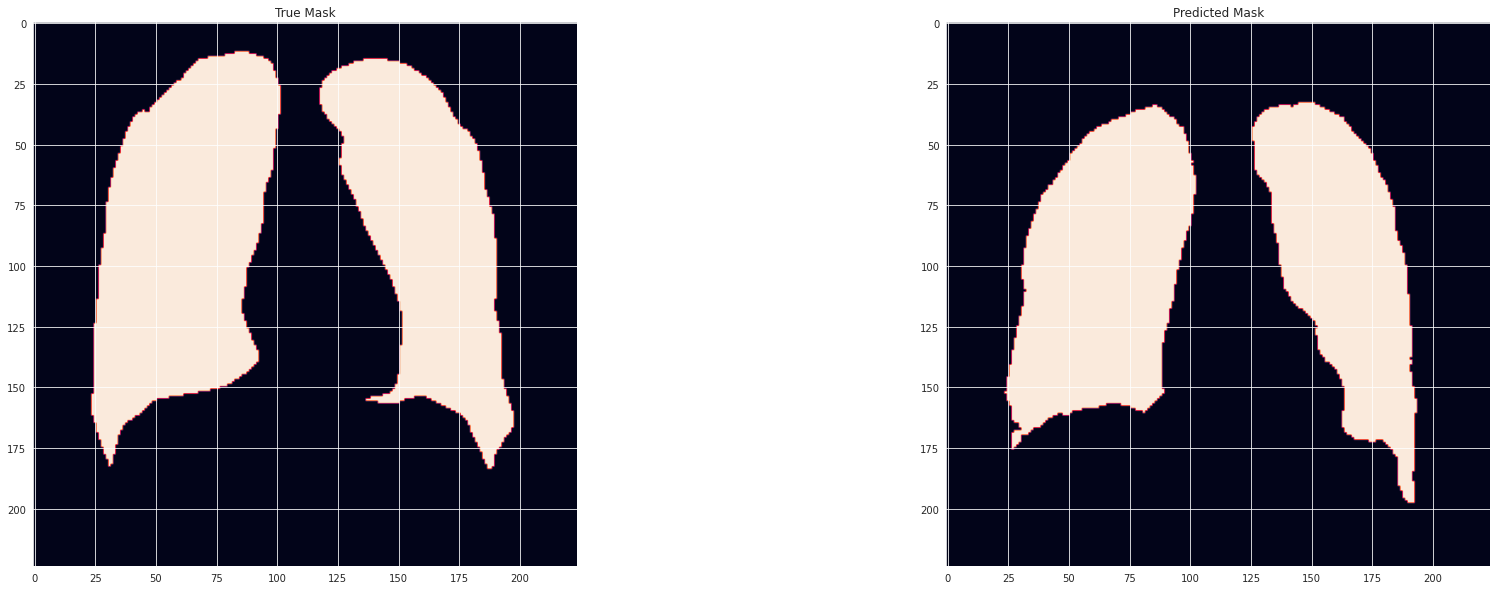

In [39]:
image_index_to_view = 1


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].imshow(array_to_img_for_viz(y_true_list[image_index_to_view]))
axes[0].set_title("True Mask")
axes[1].imshow(array_to_img_for_viz(y_pred_list[image_index_to_view]))
axes[1].set_title("Predicted Mask")